In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import power_at_resp_concat_job, oas_concat_job, bmrq_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, get_df_mask_chan_signif, keep_clean
import mne
import os
from configuration import base_folder
from params import *

In [3]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [4]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_eeg','log_max_eeg']

In [5]:
power_at_resp = power_at_resp_concat_job.get(global_key).to_dataframe()
power_at_resp['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)
power_at_resp = keep_clean(df_raw = power_at_resp, metrics_to_clean = metrics)

In [6]:
power_at_resp

,dim_0,participant,session,chan,fmax_resp,max_resp,max_eeg,stai_state,stai_trait,keep_session,Gender,Maia_Mean,OAS,BMRQ,log_max_eeg
0,0,P01,baseline,Fp1,0.36,609.15584,1.093163e-12,40,61,1,F,1.019643,2.666667,2.727273,-27.541946
1,1,P01,baseline,Fz,0.36,609.15584,2.314821e-13,40,61,1,F,1.019643,2.666667,2.727273,-29.094274
2,2,P01,baseline,F3,0.36,609.15584,9.815945e-13,40,61,1,F,1.019643,2.666667,2.727273,-27.649598
3,3,P01,baseline,F7,0.36,609.15584,3.934145e-12,40,61,1,F,1.019643,2.666667,2.727273,-26.261327
4,4,P01,baseline,FT9,0.36,609.15584,4.980288e-12,40,61,1,F,1.019643,2.666667,2.727273,-26.025533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2785,P31,odor,FC6,0.18,1967.18048,1.516793e-12,29,40,1,M,2.790774,2.933333,2.681818,-27.214423
2786,2786,P31,odor,FC2,0.18,1967.18048,1.056343e-12,29,40,1,M,2.790774,2.933333,2.681818,-27.576208
2787,2787,P31,odor,F4,0.18,1967.18048,4.175741e-12,29,40,1,M,2.790774,2.933333,2.681818,-26.201729
2788,2788,P31,odor,F8,0.18,1967.18048,4.926049e-12,29,40,1,M,2.790774,2.933333,2.681818,-26.036484


In [7]:
power_at_resp['keep_session'].value_counts()

keep_session
1    2697
0      93
Name: count, dtype: int64

<AxesSubplot: >

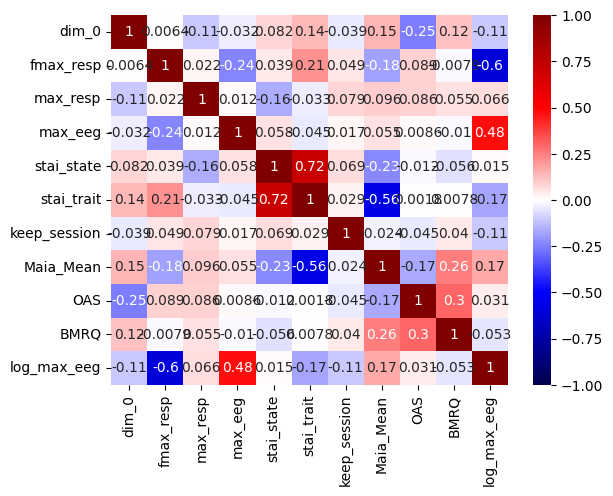

In [8]:
sns.heatmap(power_at_resp.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [9]:
power_at_resp

,dim_0,participant,session,chan,fmax_resp,max_resp,max_eeg,stai_state,stai_trait,keep_session,Gender,Maia_Mean,OAS,BMRQ,log_max_eeg
0,0,P01,baseline,Fp1,0.36,609.15584,1.093163e-12,40,61,1,F,1.019643,2.666667,2.727273,-27.541946
1,1,P01,baseline,Fz,0.36,609.15584,2.314821e-13,40,61,1,F,1.019643,2.666667,2.727273,-29.094274
2,2,P01,baseline,F3,0.36,609.15584,9.815945e-13,40,61,1,F,1.019643,2.666667,2.727273,-27.649598
3,3,P01,baseline,F7,0.36,609.15584,3.934145e-12,40,61,1,F,1.019643,2.666667,2.727273,-26.261327
4,4,P01,baseline,FT9,0.36,609.15584,4.980288e-12,40,61,1,F,1.019643,2.666667,2.727273,-26.025533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2785,P31,odor,FC6,0.18,1967.18048,1.516793e-12,29,40,1,M,2.790774,2.933333,2.681818,-27.214423
2786,2786,P31,odor,FC2,0.18,1967.18048,1.056343e-12,29,40,1,M,2.790774,2.933333,2.681818,-27.576208
2787,2787,P31,odor,F4,0.18,1967.18048,4.175741e-12,29,40,1,M,2.790774,2.933333,2.681818,-26.201729
2788,2788,P31,odor,F8,0.18,1967.18048,4.926049e-12,29,40,1,M,2.790774,2.933333,2.681818,-26.036484


<AxesSubplot: ylabel='Frequency'>

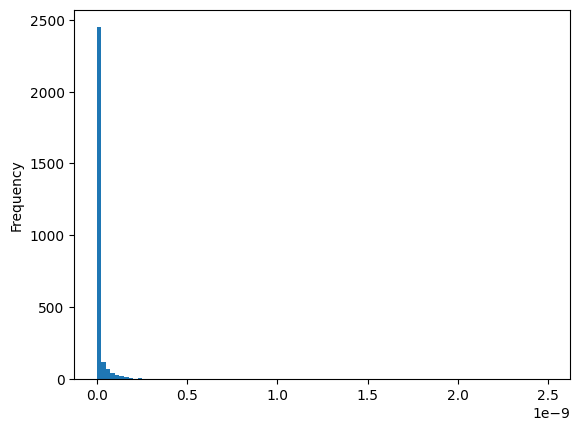

In [22]:
power_at_resp['max_eeg'].plot.hist(bins = 100)

In [10]:
power_at_resp_baselined = df_baseline(df = power_at_resp, indexes = indexes, metrics= metrics, mode = 'substract')

In [11]:
power_at_resp_baselined

,participant,session,chan,fmax_resp,max_resp,max_eeg,log_max_eeg
0,P01,odor,Fp1,0.00,-368.051215,-2.102137e-13,-0.213563
1,P01,odor,Fz,0.00,-368.051215,9.064987e-14,0.330459
2,P01,odor,F3,0.00,-368.051215,-3.419643e-13,-0.428288
3,P01,odor,F7,0.00,-368.051215,-2.030429e-12,-0.725886
4,P01,odor,FT9,0.00,-368.051215,-1.490637e-12,-0.355686
...,...,...,...,...,...,...,...
1855,P31,music,FC6,-0.06,2460.191218,8.287215e-13,0.479560
1856,P31,music,FC2,-0.06,2460.191218,3.512557e-13,0.696557
1857,P31,music,F4,-0.06,2460.191218,2.804705e-14,0.011167
1858,P31,music,F8,-0.06,2460.191218,-2.873945e-13,-0.065656


<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

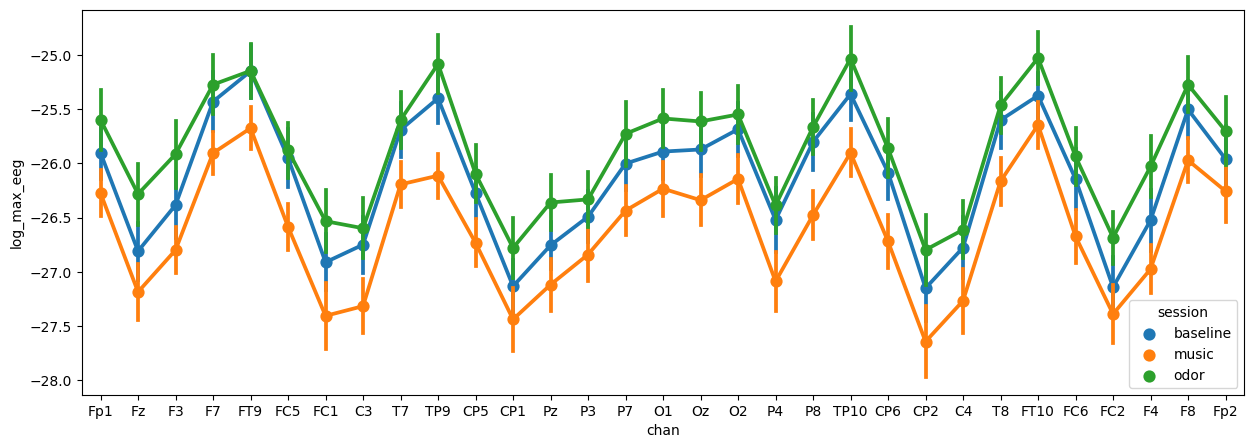

In [12]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax, errorbar = 'se')

<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

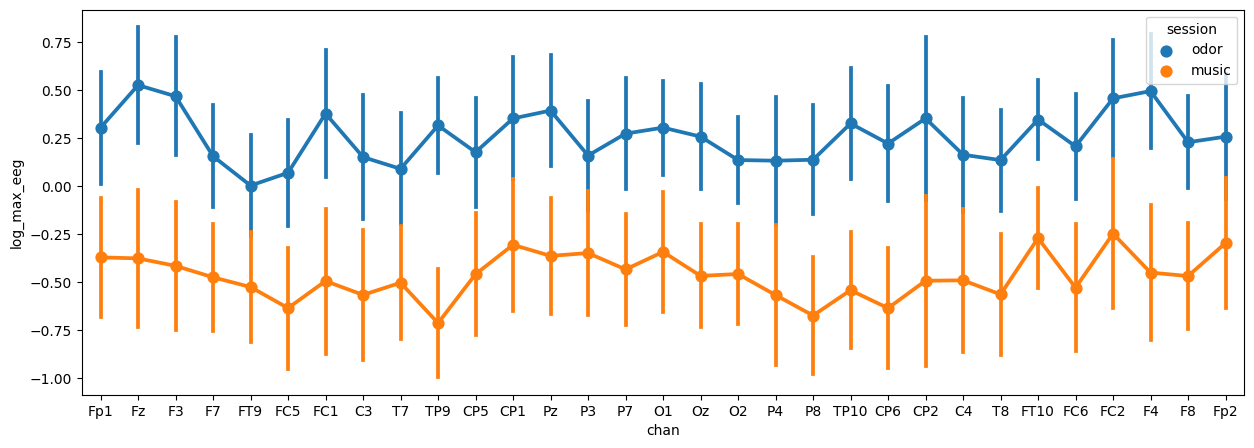

In [13]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp_baselined, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax, errorbar = 'se')

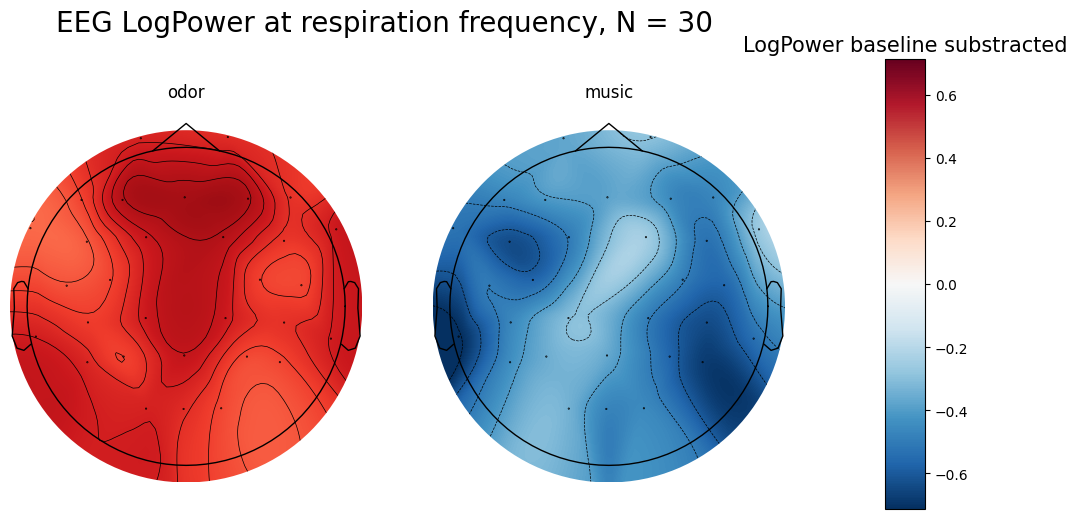

In [24]:
delta_quantile = 0.

colname = 'log_max_eeg'

df = power_at_resp_baselined

df_mask = get_df_mask_chan_signif(df = df, 
                                  chans = eeg_chans, 
                                  predictor = 'session', 
                                  outcome = 'log_max_eeg', 
                                  subject = 'participant', 
                                  multicomp_method = 'bonf', 
                                  stats_type = 'permutations',
                                 diff = 'mean')

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG LogPower at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask.reindex(eeg_chans)['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogPower baseline substracted',fontsize=15)

file = base_folder / 'Figures' / 'power_at_resp' / 'log_substracted_to_baseline.png'

# fig.savefig(file, bbox_inches = 'tight')

In [14]:
oas = oas_concat_job.get(global_key).to_dataframe().set_index('participant')
bmrq = bmrq_concat_job.get(global_key).to_dataframe().set_index('participant')

In [15]:
delta_quantile = 0.

colname = 'log_max_eeg'

for subject in subject_keys:
    
    bmrq_sub = bmrq.loc[subject, 'BMRQ'].round(3)
    oas_sub = oas.loc[subject, 'OAS'].round(3)
    
    df = power_at_resp_baselined[power_at_resp_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)

    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG LogPower at respiration frequency, sub = {subject}  \n OAS : {oas_sub} - BMRQ : {bmrq_sub}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('LogPower baseline substracted',fontsize=15)

    file = base_folder / 'Figures' / 'power_at_resp' / 'by_subject' / f'{subject}.png'

    fig.savefig(file, bbox_inches = 'tight')
    
    plt.close()

# STATS VS BASELINE

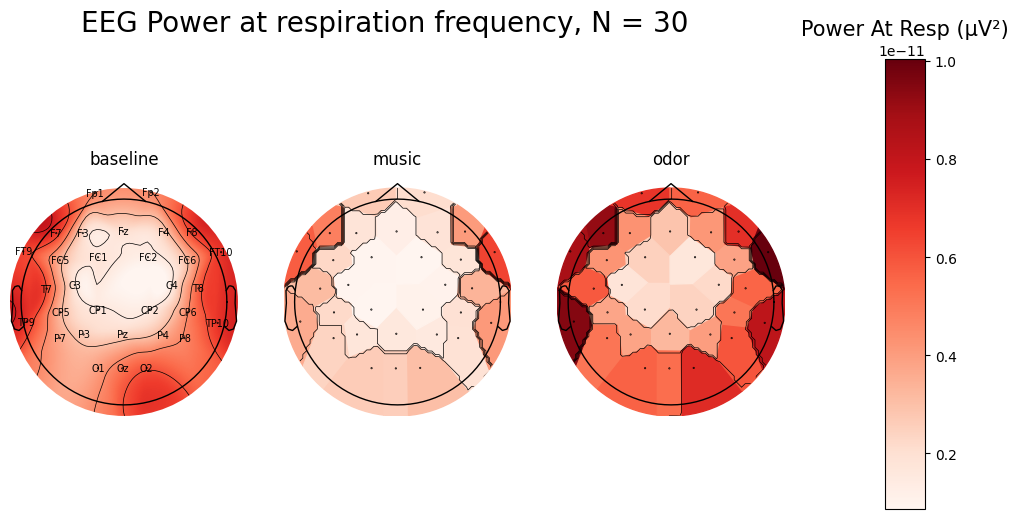

In [31]:
delta_quantile = 0.

metric = 'max_eeg'

df = power_at_resp.copy()

dfs_masks = []
for cond in ['odor','music']:
    df_to_mask = df[df['session'].isin(['baseline',cond])]
    df_mask = get_df_mask_chan_signif(df = df_to_mask, 
                                      chans = eeg_chans, 
                                      predictor = 'session', 
                                      outcome = metric, 
                                      subject = 'participant', 
                                      multicomp_method = 'bonf', 
                                      stats_type = 'permutations', 
                                      diff = 'median')
    df_mask['cond'] = cond
    dfs_masks.append(df_mask)
dfs_masks = pd.concat(dfs_masks)

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).median(numeric_only = True)[metric].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).median(numeric_only = True)[metric].values, 1 - delta_quantile)

# vmin = vmin if abs(vmin) > abs(vmax) else -vmax
# vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG Power at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params, image_interp = 'nearest')
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Power At Resp (µV²)',fontsize=15)

file = base_folder / 'Figures' / 'power_at_resp' / 'raw__power_at_resp_permutations.png'

fig.savefig(file, bbox_inches = 'tight')